# Personality and preferences for movies analysis

Data come from: https://www.kaggle.com/datasets/arslanali4343/top-personality-dataset

### The purpose of research: 

The aim of the study is to create an algorithm that predict the level of satisfaction with watching movies from the suggested list based on the personality traits of the Big Five Personality model and the method of assigning a preferred list of films.


### Loading required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from imblearn.over_sampling import SMOTE

### Loading data and checking features

In [2]:
df = pd.read_csv("2018-personality-data.csv")

In [3]:
df.head(3)

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned metric,assigned condition,movie_1,predicted_rating_1,...,movie_9,predicted_rating_9,movie_10,predicted_rating_10,movie_11,predicted_rating_11,movie_12,predicted_rating_12,is_personalized,enjoy_watching
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,serendipity,high,77658,4.410466,...,120138,4.244817,121372,4.396004,127152,4.120456,95311,4.053847,4,4
1,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0,all,default,94959,4.207280,...,56782,4.019599,5618,3.963953,969,4.174188,1232,4.334877,2,3
2,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5,serendipity,medium,110501,4.868064,...,2288,4.823212,3307,4.676756,1172,4.649281,1212,4.744990,2,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834 entries, 0 to 1833
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   userid                1834 non-null   object 
 1    openness             1834 non-null   float64
 2    agreeableness        1834 non-null   float64
 3    emotional_stability  1834 non-null   float64
 4    conscientiousness    1834 non-null   float64
 5    extraversion         1834 non-null   float64
 6    assigned metric      1834 non-null   object 
 7    assigned condition   1834 non-null   object 
 8    movie_1              1834 non-null   int64  
 9    predicted_rating_1   1834 non-null   float64
 10   movie_2              1834 non-null   int64  
 11   predicted_rating_2   1834 non-null   float64
 12   movie_3              1834 non-null   int64  
 13   predicted_rating_3   1834 non-null   float64
 14   movie_4              1834 non-null   int64  
 15   predicted_rating_4  

There are no missing data in set. 

Remove spaces from the beginning of all column names and correct names two of them.

In [5]:
df.columns = df.columns.str.replace(' ', '')

In [6]:
df.rename({'assignedmetric': 'assigned_metric', 'assignedcondition': 'assigned_condition'}, inplace=True, axis='columns')

Data about movies will not be used in the research and therefore are deleted.

In [7]:
for i in range(1,13):
    df.drop([f"movie_{i}",f"predicted_rating_{i}" ], axis=1, inplace=True)

In [8]:
df.drop(["userid"], axis=1, inplace=True)

In [9]:
df.head()

,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned_metric,assigned_condition,is_personalized,enjoy_watching
0,5.0,2.0,3.0,2.5,6.5,serendipity,high,4,4
1,7.0,4.0,6.0,5.5,4.0,all,default,2,3
2,4.0,3.0,4.5,2.0,2.5,serendipity,medium,2,2
3,5.5,5.5,4.0,4.5,4.0,popularity,medium,3,3
4,5.5,5.5,3.5,4.5,2.5,popularity,medium,2,3


In [10]:
df["assigned_metric"].value_counts()

 popularity     574
 serendipity    532
 diversity      520
 all            208
Name: assigned_metric, dtype: int64

In [11]:
df["assigned_condition"].value_counts()

 high       554
 medium     538
 low        534
 default    208
Name: assigned_condition, dtype: int64

In [12]:
df.describe()

,openness,agreeableness,emotional_stability,conscientiousness,extraversion,is_personalized,enjoy_watching
count,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000
mean,5.376499,4.215921,4.561614,4.662486,3.485551,3.056707,3.517993
std,1.042804,1.137923,1.392548,1.311450,1.468503,1.078507,1.059060
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.500000,3.500000,3.500000,4.000000,2.500000,2.000000,3.000000
50%,5.500000,4.000000,4.500000,4.500000,3.500000,3.000000,4.000000
75%,6.000000,5.000000,5.500000,5.500000,4.500000,4.000000,4.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,5.000000,5.000000


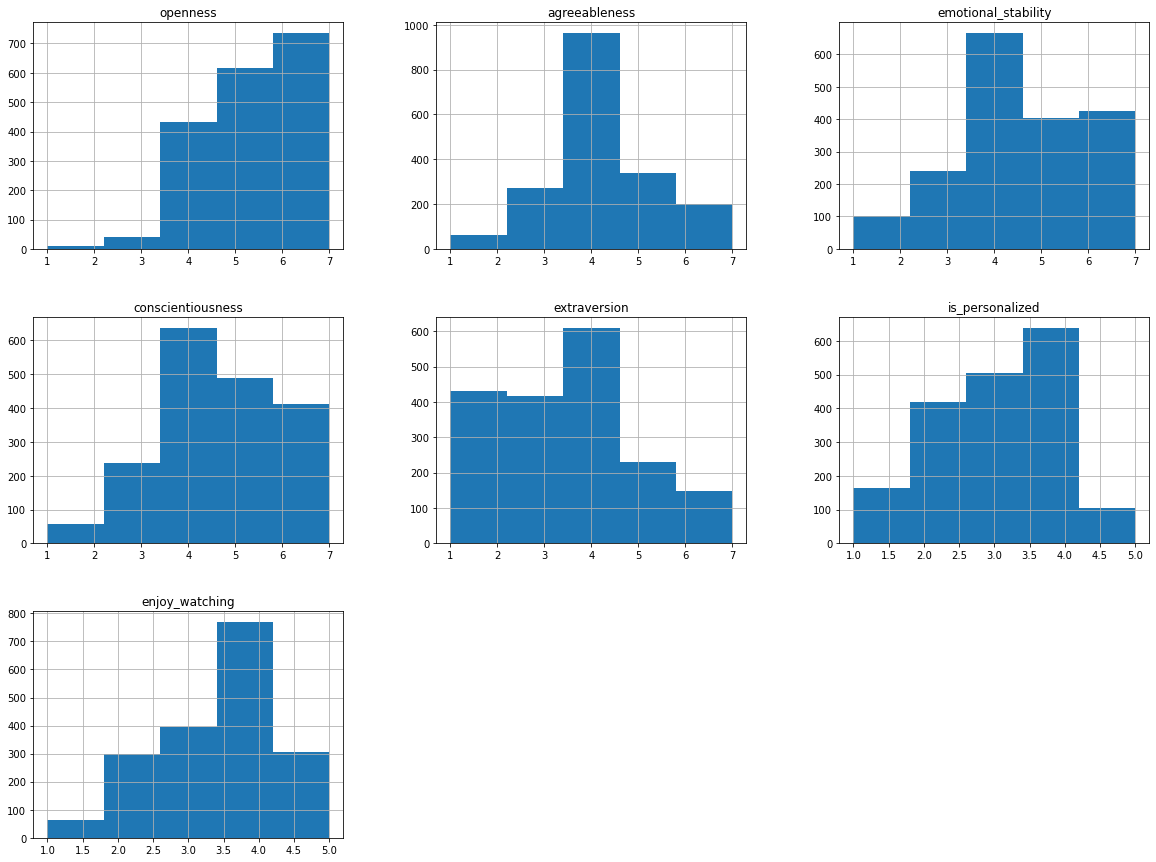

In [13]:
df.hist(bins=5, figsize=(20,15))
plt.show()

### Test for normality of distribution

H0: sample comes from a normal distribution

H1: sample does not come from a normal distribution

In [14]:
list_col = []
for i in range(0,9):
    list_col += [df.columns[i]]

In [15]:
del list_col[5:7]

In [16]:
len(list_col)

7

In [17]:
for i in range(len(list_col)):
    shapiro = stats.shapiro(df[list_col[i]])
    print(f"For {list_col[i]}: statistic = {np.round(shapiro, 3)[0]}, p-value = {np.round(shapiro,3)[1]}")

For openness: statistic = 0.956, p-value = 0.0
For agreeableness: statistic = 0.976, p-value = 0.0
For emotional_stability: statistic = 0.973, p-value = 0.0
For conscientiousness: statistic = 0.974, p-value = 0.0
For extraversion: statistic = 0.969, p-value = 0.0
For is_personalized: statistic = 0.898, p-value = 0.0
For enjoy_watching: statistic = 0.885, p-value = 0.0


All null hypothesis can be rejected. Samples do not come from normal distrbution. 

### Target variable

In [18]:
df["enjoy_watching"].value_counts()

4    769
3    396
5    305
2    299
1     65
Name: enjoy_watching, dtype: int64

### Correlation checking

Pearson's correlaction can not be used because samples do not come from normal distrbution, so it is used Spearman's rank correlation. 

H0: target variable is correlated with independent variable

H1: target variable is not correlated with independent variable

In [19]:
stat, p = stats.spearmanr(df)
for i in range(0,len(df.columns)-1):
    print(f"For enjoy_watching and {df.columns[i]}: statistic = {np.round(stat, 3)[i,8]}, p-value = {np.round(p, 3)[i,8]}")

For enjoy_watching and openness: statistic = 0.064, p-value = 0.006
For enjoy_watching and agreeableness: statistic = 0.034, p-value = 0.142
For enjoy_watching and emotional_stability: statistic = 0.003, p-value = 0.886
For enjoy_watching and conscientiousness: statistic = -0.044, p-value = 0.059
For enjoy_watching and extraversion: statistic = 0.029, p-value = 0.217
For enjoy_watching and assigned_metric: statistic = -0.019, p-value = 0.424
For enjoy_watching and assigned_condition: statistic = 0.007, p-value = 0.754
For enjoy_watching and is_personalized: statistic = 0.63, p-value = 0.0


For enjoy_watching and openness as well as enjoy_watching and is_personalized null hypotheses can not be rejected. There is significant correlation between them. 
For the rest variables null hypotheses can be rejected. There is not significant correlation between them. 

Openness in Big Five Personality Traits describes the need to look for new experiences and peeling them positively, curiosity, tolerance for new things. So that is why it is significat related with receiving film suggestions. 

It can be assumed that people are more happy with watching films when they assume that suggested list is personalised for them. 

### Prepare data to machine learning

Levels 1 and 2 for enjoy watching were the smallest, so they were added together.

In [20]:
df["enjoy_watching_new"] = df ["enjoy_watching"].apply(lambda x: x*2 if x==1 else x)
df["enjoy_watching_new"].value_counts()

4    769
3    396
2    364
5    305
Name: enjoy_watching_new, dtype: int64

In [21]:
df1 = df.drop("enjoy_watching", axis=1)

In [22]:
df1.head(2)

,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned_metric,assigned_condition,is_personalized,enjoy_watching_new
0,5.0,2.0,3.0,2.5,6.5,serendipity,high,4,4
1,7.0,4.0,6.0,5.5,4.0,all,default,2,3


In [23]:
X = df1.drop("enjoy_watching_new", axis=1)
y = df1.enjoy_watching_new

In [24]:
X = pd.get_dummies(X)
X.head(3)

,openness,agreeableness,emotional_stability,conscientiousness,extraversion,is_personalized,assigned_metric_ all,assigned_metric_ diversity,assigned_metric_ popularity,assigned_metric_ serendipity,assigned_condition_ default,assigned_condition_ high,assigned_condition_ low,assigned_condition_ medium
0,5.0,2.0,3.0,2.5,6.5,4,0,0,0,1,0,1,0,0
1,7.0,4.0,6.0,5.5,4.0,2,1,0,0,0,1,0,0,0
2,4.0,3.0,4.5,2.0,2.5,2,0,0,0,1,0,0,0,1


### Spliting data set

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Base models

The data will first be checked against default models.

To improve the work, will be used a prepared function to create a model and its evaluation.

In [26]:
def model_and_evaluate(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    y_model = model.predict(X_test)
    test_score = accuracy_score(y_test, 
                                model.predict(X_test))
    
    return test_score

For the model fitting, I will try out the following:
1. Logistic Regression
2. Decision Tree
3. Linear SVC
4. Random Forest
5. AdaBoost
6. GradientBoosting

In [27]:
models = [LogisticRegression(), DecisionTreeClassifier(), LinearSVC(), RandomForestClassifier(), 
          AdaBoostClassifier(), GradientBoostingClassifier()]

for model in models:
    print(model)
    print(model_and_evaluate(model, X_train, y_train, X_test, y_test))

LogisticRegression()


/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5613079019073569
DecisionTreeClassifier()
0.4550408719346049
LinearSVC()


/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.5313351498637602
RandomForestClassifier()
0.553133514986376
AdaBoostClassifier()
0.5177111716621253
GradientBoostingClassifier()
0.5613079019073569


All models handle the data at a similar level, so I reject the two with the lowest Accuracy Score and will run GridSearchCV and RandomizedSearchCV on the remaining four to see if it is possible to find a better model.

### Selection model and hyperparamets
The function for building and evaluating the model will be created again.

In [28]:
def optimize_and_evaluate_grid(model, param_distr, X_train, y_train, X_test, y_test):
    
    optimizer = GridSearchCV(model, 
                         param_distr, 
                         cv=10, 
                         scoring="accuracy",
                         n_jobs=-1)
    optimizer.fit(X_train, y_train)

    best_params = optimizer.best_params_
    test_score = accuracy_score(y_test, 
                                optimizer.best_estimator_.predict(X_test))
    
    return test_score, best_params

def optimize_and_evaluate_random(model, param_distr, X_train, y_train, X_test, y_test):
    
    optimizer = RandomizedSearchCV(model, 
                         param_distr, 
                         cv=10, 
                         scoring="accuracy",
                         n_jobs=-1)
    optimizer.fit(X_train, y_train)

    best_params = optimizer.best_params_
    test_score = accuracy_score(y_test, 
                                optimizer.best_estimator_.predict(X_test))
    
    return test_score, best_params

In [29]:
lr = LogisticRegression()
param_lr =[
    {"penalty": ["none", "l2", "l1", "elasticnet"],
     "C":[0.1, 1, 10],
     "max_iter": [1000]}]
lr_gr = optimize_and_evaluate_grid(lr, param_lr, X_train, y_train, X_test, y_test)
lr_rd = optimize_and_evaluate_random(lr, param_lr, X_train, y_train, X_test, y_test)
print(lr_gr)
print (lr_rd)

/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/agnieszka/opt/anaconda3

(0.5640326975476839, {'C': 10, 'max_iter': 1000, 'penalty': 'l2'})
(0.5640326975476839, {'penalty': 'none', 'max_iter': 1000, 'C': 10})


/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_lo

In [30]:
lsvc = LinearSVC()
param_lsvc =[
    {"C": [0.1, 1, 10],
     "max_iter": [500, 1000]}]
lsvc_gr = optimize_and_evaluate_grid(lsvc, param_lsvc, X_train, y_train, X_test, y_test)
lsvc_rd = optimize_and_evaluate_random(lsvc, param_lsvc, X_train, y_train, X_test, y_test)
print(lsvc_gr)
print (lsvc_rd)

/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/s

/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/s

(0.5340599455040872, {'C': 0.1, 'max_iter': 500})
(0.5340599455040872, {'max_iter': 500, 'C': 0.1})


In [31]:
rfc = RandomForestClassifier()
param_rfc=[{"n_estimators": [100, 250],
     "min_samples_leaf": [1, 5],
     "max_samples": [0.75, 1]}]
rfc_gr = optimize_and_evaluate_grid(rfc, param_rfc, X_train, y_train, X_test, y_test)
rfc_rd = optimize_and_evaluate_random(rfc, param_rfc, X_train, y_train, X_test, y_test)
print(rfc_gr)
print (rfc_rd)

/Users/agnieszka/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


(0.5885558583106267, {'max_samples': 0.75, 'min_samples_leaf': 5, 'n_estimators': 250})
(0.5803814713896458, {'n_estimators': 250, 'min_samples_leaf': 5, 'max_samples': 0.75})


In [32]:
gbc = GradientBoostingClassifier()
param_gbc= [{"n_estimators": [50, 100], 
     "learning_rate": [0.1, 1, 10], 
     "max_depth": [3, 5]}]
gbc_gr = optimize_and_evaluate_grid(gbc, param_gbc, X_train, y_train, X_test, y_test)
gbc_rd = optimize_and_evaluate_random(gbc, param_gbc, X_train, y_train, X_test, y_test)
print(gbc_gr)
print (gbc_rd)

(0.5858310626702997, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50})
(0.5858310626702997, {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1})


The best Accuracy result is for the Random Forest algorithm obtained by the GridSearchCV method with the hyperparameters max_samples: 0.75, min_samples_leaf: 5, n_estimators: 250.
Due to the fact that the hyperparameters are at the edges of the ranges, it will be conducted another search to see if the change of hyperparameters improve Accuracy.

In [33]:
rfc = RandomForestClassifier()
param_rfc1=[{"n_estimators": [100, 250, 500],
     "min_samples_leaf": [1, 5, 7],
     "max_samples": [0.75, 1, 5]}]
rfc1_gr = optimize_and_evaluate_grid(rfc, param_rfc1, X_train, y_train, X_test, y_test)

print(rfc1_gr)

(0.5640326975476839, {'max_samples': 0.75, 'min_samples_leaf': 5, 'n_estimators': 100})


The change of hyperparameters does not come the better Accuracy.

### SMOTE for unbalansed data

Due to unbalanced data it will be checked whether the application of the SMOTE method improve the results for the chosen algorithm.

In [34]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=1)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [35]:
rfcsm = RandomForestClassifier(max_samples=0.75, min_samples_leaf=5, n_estimators=250)
model_and_evaluate(rfcsm, Xsm_train, ysm_train, X_test, y_test)

0.5149863760217984

The method does not improve Accuracy.

### Summary

The best model based on Random Forest algorithm with parameters: max_samples: 0.75, min_samples_leaf: 5, n_estimators: 250. Accuracy for this model is 0.589.

Statistic research show that varable enjoy_watching is correlated with opennes ans is personalized.

The results reflect the unbalanced data set and this tool to describe the features of the Big Five - the TIPI questionnaire used contains two questions for each of the features, and an in-depth personality analysis could reveal a connection between factors other than openness to experience. Additionally, to obtain a better fit of the data to the algorithm, it might be helpful to expand the data on the suggested movies.